##### Adapted from https://github.com/ShawnHymel/tflite-speech-recognition


In [74]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [75]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path='/content/drive/MyDrive/Deep Learning/Datasets/speech commands'
#colab specific

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# Create list of all targets (minus background noise)
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
#all_targets.remove('_background_noise_')
print(all_targets)

['four', '_background_noise_', 'stop', 'go', 'left', 'down', 'eight', 'five', 'zero', 'no', 'three']


In [77]:
# Settings
feature_sets_path = '/content/drive/MyDrive/Deep Learning'
feature_sets_filename = 'all_targets_mfcc.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop'

In [78]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_tr', 'y_tr', 'x_va', 'y_va', 'x_te', 'y_te']


In [79]:
# Assign feature sets
x_train = feature_sets['x_tr']
y_train = feature_sets['y_tr']
x_val = feature_sets['x_va']
y_val = feature_sets['y_va']
x_test = feature_sets['x_te']
y_test = feature_sets['y_te']

In [80]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1391, 16, 16)
(170, 16, 16)
(170, 16, 16)


In [81]:
# Peek at labels
print(y_val)

[4. 0. 8. 8. 8. 5. 7. 5. 5. 0. 5. 3. 4. 3. 5. 3. 0. 3. 7. 5. 2. 7. 4. 2.
 2. 6. 3. 3. 4. 0. 2. 4. 7. 0. 7. 2. 3. 4. 3. 3. 7. 7. 0. 3. 2. 7. 0. 2.
 3. 7. 4. 3. 0. 6. 4. 8. 8. 2. 4. 4. 7. 4. 2. 0. 3. 7. 2. 7. 5. 2. 4. 4.
 0. 8. 0. 5. 0. 3. 2. 2. 8. 0. 0. 8. 6. 7. 8. 8. 7. 2. 6. 4. 2. 4. 2. 2.
 4. 2. 3. 2. 7. 4. 6. 3. 5. 4. 2. 5. 2. 0. 7. 0. 0. 6. 4. 5. 8. 5. 0. 7.
 3. 6. 8. 7. 7. 5. 4. 3. 5. 8. 5. 7. 3. 3. 2. 0. 4. 2. 0. 0. 7. 8. 8. 7.
 4. 5. 7. 8. 8. 5. 2. 0. 0. 8. 3. 7. 3. 2. 7. 3. 8. 8. 0. 3. 0. 3. 2. 5.
 6. 2.]


In [82]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [83]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1.]


In [84]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.1588235294117647
0.8411764705882353


In [85]:
# View the dimensions of our input data
print(x_train.shape)

(1391, 16, 16)


In [86]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1391, 16, 16, 1)
(170, 16, 16, 1)
(170, 16, 16, 1)


In [87]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [88]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [89]:
# Display model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 64)        

In [90]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [91]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
14/14 [==============================] - 2s 42ms/step - loss: 0.4231 - acc: 0.8519 - val_loss: 0.4013 - val_acc: 0.8412
Epoch 2/30
14/14 [==============================] - 0s 28ms/step - loss: 0.3485 - acc: 0.8735 - val_loss: 0.4113 - val_acc: 0.8412
Epoch 3/30
14/14 [==============================] - 0s 28ms/step - loss: 0.3253 - acc: 0.8749 - val_loss: 0.3889 - val_acc: 0.8529
Epoch 4/30
14/14 [==============================] - 0s 28ms/step - loss: 0.3130 - acc: 0.8785 - val_loss: 0.3593 - val_acc: 0.8412
Epoch 5/30
14/14 [==============================] - 0s 27ms/step - loss: 0.2908 - acc: 0.8749 - val_loss: 0.4040 - val_acc: 0.8412
Epoch 6/30
14/14 [==============================] - 0s 26ms/step - loss: 0.2627 - acc: 0.8936 - val_loss: 0.3529 - val_acc: 0.8412
Epoch 7/30
14/14 [==============================] - 0s 26ms/step - loss: 0.2660 - acc: 0.9008 - val_loss: 0.2946 - val_acc: 0.8471
Epoch 8/30
14/14 [==============================] - 0s 28ms/step - loss: 0.2336 - a

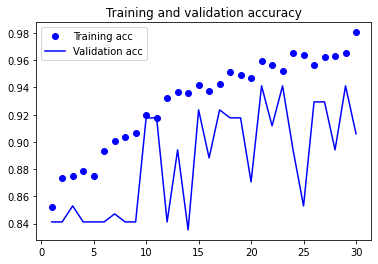

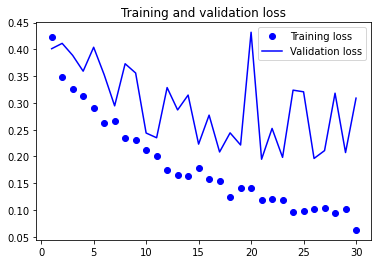

In [92]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [93]:
# Save the model as a file
models.save_model(model, model_filename)

In [94]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

9
10
13
38
46
48
51
59
60
62
69
76
81
84
95
96
100
111
124
125
133
147
156


In [98]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(70, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[5.0387607e-05]]
Answer: 0.0  Prediction: [[0.01465863]]
Answer: 0.0  Prediction: [[0.00050879]]
Answer: 0.0  Prediction: [[0.0024277]]
Answer: 0.0  Prediction: [[7.5121574e-07]]
Answer: 0.0  Prediction: [[0.02725196]]
Answer: 1.0  Prediction: [[0.78513825]]
Answer: 0.0  Prediction: [[1.7357391e-06]]
Answer: 0.0  Prediction: [[9.240482e-05]]
Answer: 0.0  Prediction: [[0.06403828]]
Answer: 0.0  Prediction: [[4.0063137e-06]]
Answer: 1.0  Prediction: [[0.93242335]]
Answer: 0.0  Prediction: [[0.00104359]]
Answer: 0.0  Prediction: [[3.143706e-05]]
Answer: 1.0  Prediction: [[0.9919349]]
Answer: 0.0  Prediction: [[0.00062105]]
Answer: 0.0  Prediction: [[0.00224823]]
Answer: 0.0  Prediction: [[1.8608333e-07]]
Answer: 0.0  Prediction: [[0.07387683]]
Answer: 0.0  Prediction: [[0.00822547]]
Answer: 0.0  Prediction: [[0.00036147]]
Answer: 0.0  Prediction: [[0.00172582]]
Answer: 0.0  Prediction: [[1.8795326e-08]]
Answer: 0.0  Prediction: [[4.1275553e-06]]
Answer: 0.0  Pred

In [96]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

6/6 [==============================] - 0s 6ms/step - loss: 0.2510 - acc: 0.9353


[0.2509542405605316, 0.9352940917015076]